In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

import itertools

In [31]:
sns.set(color_codes=True)

In [5]:
PARAMS = np.array([[0, 1],
                   [2, 4]])
SEED = 1984

In [178]:
def get_data(alphas, deltas, sample_size=10000, criteria=True, verbose=True, seed=SEED, only_stat=False):
    """
    alphas: list of alphas, size=n
    deltas: list of deltas, size=n
    n_samples: array of numbers of samples to create in each serie, size=n
    seed: random seed, integer
    
    returns: array of shape n, which contains:
        case only_stat=False:
            tuples of:
            1) data of X1, array of n_samples
            2) data of X2, array of n_samples
            3) criteria p-value(optionally), int
        case only_stat=True:
            criteria p-value, int
    """
    #assert len(alphas) == len(deltas)
    
    np.random.seed(seed)
    n = len(alphas)
    
    result = [None] * n
    for i in range(n):
        alpha = alphas[i]
        delta = deltas[i]
        
        #assert alpha <= 1
        
        weights = [alpha, 1-alpha]
        
        mixture_idx = np.random.choice([0, 1], size=sample_size, replace=True, p=weights)
        X_1 = np.fromiter((np.random.normal(*(PARAMS[index])) for index in mixture_idx),
                          dtype=np.float64)
        X_2 = np.fromiter((np.random.normal(*(PARAMS[index])) for index in mixture_idx),
                          dtype=np.float64) + delta
        
        if criteria:
            T = st.wilcoxon(X_2 - X_1)
            
        if verbose:
            print("alpha = {}, delta = {}".format(alpha, delta))
            if criteria:
                print("Wilcoxon p-value: {}".format(T[1]))
            print("--------------------------------------")
        
        if only_stat:
            result[i] = T[1]
        else:
            result[i] = ((X_1, X_2, T[1]))

    return result

Let's look what our samples look like:

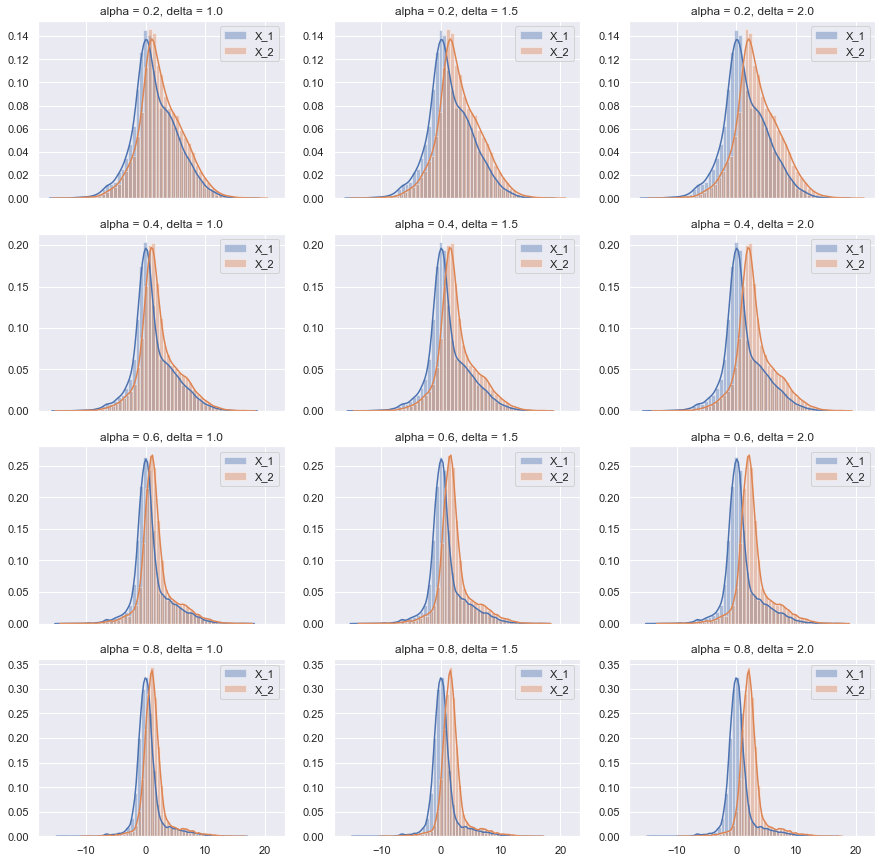

In [69]:
alphas = np.arange(0.2, 1.0, 0.2)
deltas = np.arange(1, 2.5, 0.5)

_, axes = plt.subplots(alphas.shape[0], deltas.shape[0],
                       figsize=(15, 15), sharex=True)

for element in itertools.product(*(range(alphas.shape[0]), range(deltas.shape[0]))):
    alpha = alphas[element[0]]
    delta = deltas[element[1]]
    results = get_data([alpha], [delta], verbose=False)
    sns.distplot(results[0][0], label="X_1", bins=50, ax=axes[element[0], element[1]])
    sns.distplot(results[0][1], label="X_2", bins=50, ax=axes[element[0], element[1]]) \
    .set(title="alpha = {}, delta = {}".format(*np.around([alpha, delta], decimals=1)))
    axes[element[0], element[1]].legend()
plt.show()

Как уже можно заметить из графиков, нас будут интересовать значения $\delta \ll 1$, критерий хорошо выполняет свою работу при больших значениях.
Теперь проиллюстрируем зависимость p-value от $\delta$ и $\alpha$ уже более тщательно, причем в процессе будем генерировать несколько выборок и усреднять:

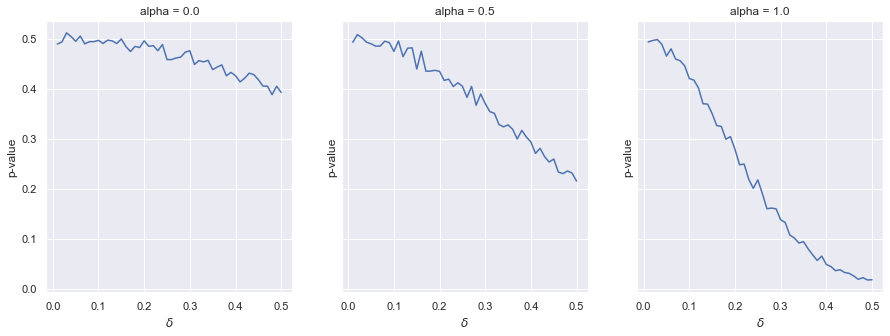

In [126]:
n_alphas = 3
n_deltas = 50
n_samples = 1000
sample_size = 100

alphas = np.linspace(0, 1, n_alphas)
deltas = np.linspace(0.01, 0.5, n_deltas)

_, axes = plt.subplots(1, alphas.shape[0],
                       figsize=(15, 5), sharex=True, sharey=True)

for idx, alpha in enumerate(alphas):
    pvalues = np.zeros((n_samples, n_deltas))
    for i in range(n_samples):
        results = get_data(np.full_like(deltas, alpha), deltas, 
                           sample_size=sample_size, seed=idx * n_samples + i, verbose=False)
        pvalues[i,:] = np.array([x[2] for x in results])
    
    sns.lineplot(x=deltas, y=pvalues.mean(axis=0), ax=axes[idx])\
    .set(title="alpha = {}".format(*np.around([alpha], decimals=1)),
        xlabel="$\delta$", ylabel="p-value")
plt.show()

Из графиков можно заметить две вещи:
<ul>
    <li>чем меньше параметр $\alpha$, тем хуже работает критерий, по крайней мере на интересующих нас значениях $\delta$;</li>
    <li>даже значения $\delta$ равные 0.5 не позволяют уверенно отвергать гипотезу на размерах выборки 100 при всех $\alpha$ </li>
</ul>

Теперь посмотрим детальнее на $\alpha$:

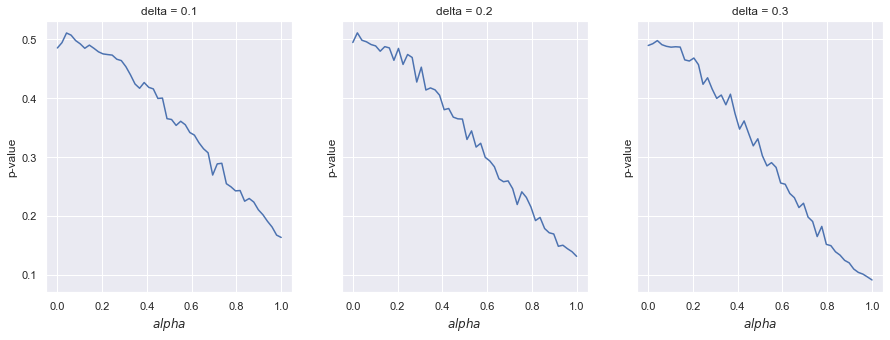

In [125]:
n_alphas = 50
n_deltas = 3
n_samples = 1000
sample_size = 100

deltas = np.linspace(0.1, 0.3, n_deltas)
alphas = np.linspace(0.0, 1.0, n_alphas)

_, axes = plt.subplots(1, deltas.shape[0],
                       figsize=(15, 5), sharex=True, sharey=True)

for idx, delta in enumerate(deltas):
    pvalues = np.zeros((n_samples, n_alphas))
    for i in range(n_samples):
        results = get_data(np.full_like(alphas, delta), alphas, 
                           sample_size=sample_size, seed=n_samples*idx + i, verbose=False)
        pvalues[i, :] = np.array([x[2] for x in results])
        
    sns.lineplot(x=alphas, y=pvalues.mean(axis=0), ax=axes[idx])\
    .set(title="delta = {}".format(*np.around([delta], decimals=2)),
        xlabel="$alpha$", ylabel="p-value")
plt.show()

Теперь зависимость качества критерия от $\alpha$ видна ярко, также можно заметить, что увеличение $\delta$ равномерно "улучшает" работу критерия.

Однако нас интересует мощность, то есть вероятность принятия альтернативы, когда выборки раздельны, и консервативность, то есть является ли практически получаемый p-value выше или ниже заявленного. Будем проводить все эксперименты для стандартного уровня доверия в 5%:

## Мощность и консервативность

Просто посчитаем долю выборок, которые отвергаются - это и будет мощность. Консервативность будем измерять так - посчитаем средний
<br>
p-value для данных параметров, после чего посчитаем долю выборок, на которых p-value было меньше - то есть измерим тенденцию статистики к завышению p-value. 


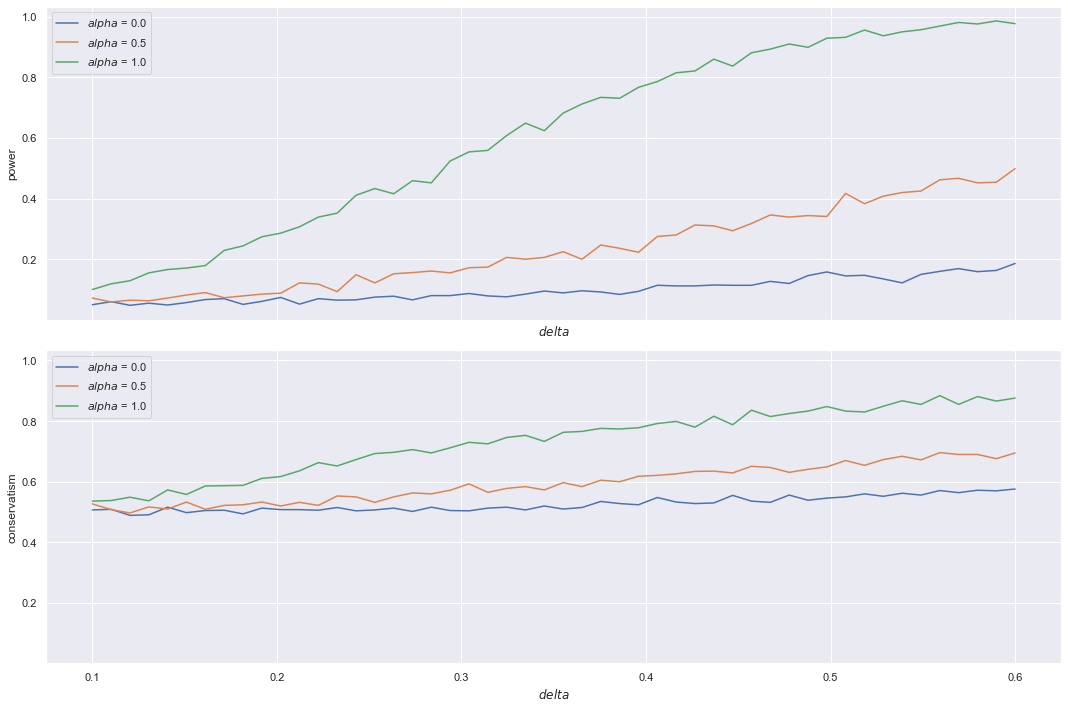

In [170]:
n_alphas = 3
n_deltas = 50
n_samples = 1000
sample_size = 100
# также было принято решение слегка поправить границы рассматриваемых delta

alphas = np.linspace(0, 1, n_alphas)
deltas = np.linspace(0.1, 0.6, n_deltas)

fig, axes = plt.subplots(2, 1,
                       figsize=(15, 10), sharex=True, sharey=True)

for idx, alpha in enumerate(alphas):
    pvalues = np.zeros((n_samples, n_deltas))
    for i in range(n_samples):
        results = get_data(np.full_like(deltas, alpha), deltas, 
                           sample_size=sample_size, seed=idx * n_samples + i, verbose=False)
        pvalues[i,:] = np.array([x[2] for x in results])
    
    sns.lineplot(x=deltas, y=(pvalues<0.05).mean(axis=0), ax=axes[0], 
                 label="$alpha$ = {}".format(*np.around([alpha], decimals=2)))
    sns.lineplot(x=deltas, y=(pvalues<pvalues.mean(axis=0)).mean(axis=0), ax=axes[1],
                label="$alpha$ = {}".format(*np.around([alpha], decimals=2)))
axes[0].set(xlabel="$delta$", ylabel="power")
axes[1].set(xlabel="$delta$", ylabel="conservatism")
fig.tight_layout()
plt.show()

Явно видно зависимость и от $\alpha$, и от $\delta$, однако сами по себе значения мощности довольно печальны для всех $\delta < 0.4$
<br>
Графики консервативности ясно показывают, что при увеличении и $\delta$, и $\alpha$ доля "заниженных" показателей выборок возрастает, что мы чаще будем отвергать больше аналогичных выборок, чем могли бы предположить, исходя из p-value.
<br>
(Размер выборки все ещё 100)

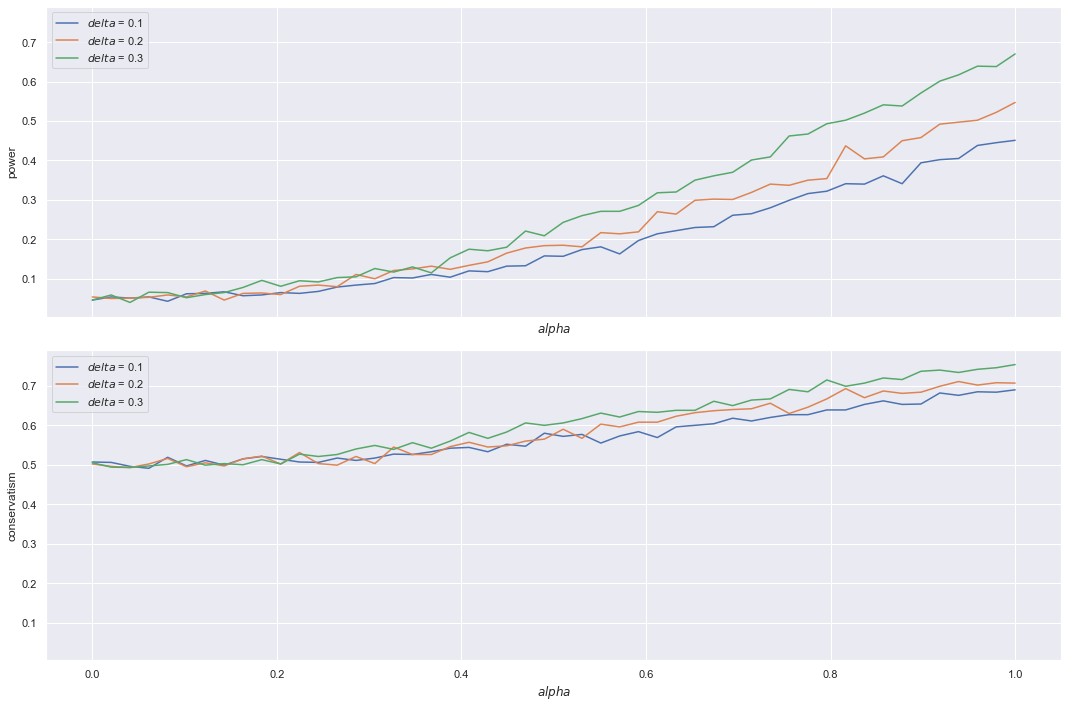

In [172]:
n_alphas = 50
n_deltas = 3
n_samples = 1000
sample_size = 100

deltas = np.linspace(0.1, 0.3, n_deltas)
alphas = np.linspace(0.0, 1.0, n_alphas)

fig, axes = plt.subplots(2, 1,
                       figsize=(15, 10), sharex=True, sharey=True)

for idx, delta in enumerate(deltas):
    pvalues = np.zeros((n_samples, n_alphas))
    for i in range(n_samples):
        results = get_data(np.full_like(alphas, delta), alphas, 
                           sample_size=sample_size, seed=n_samples*idx + i, verbose=False)
        pvalues[i, :] = np.array([x[2] for x in results])
        
    sns.lineplot(x=alphas, y=(pvalues<0.05).mean(axis=0), ax=axes[0], 
                 label="$delta$ = {}".format(*np.around([delta], decimals=2)))
    sns.lineplot(x=alphas, y=(pvalues<pvalues.mean(axis=0)).mean(axis=0), ax=axes[1],
                label="$delta$ = {}".format(*np.around([delta], decimals=2)))
axes[0].set(xlabel="$alpha$", ylabel="power")
axes[1].set(xlabel="$alpha$", ylabel="conservatism")
fig.tight_layout()
plt.show()

Наблюдаем аналогичную ситуацию. Теперь настал черед проверить зависимость этих характеристик от размеров выборки.

## Размер выборки

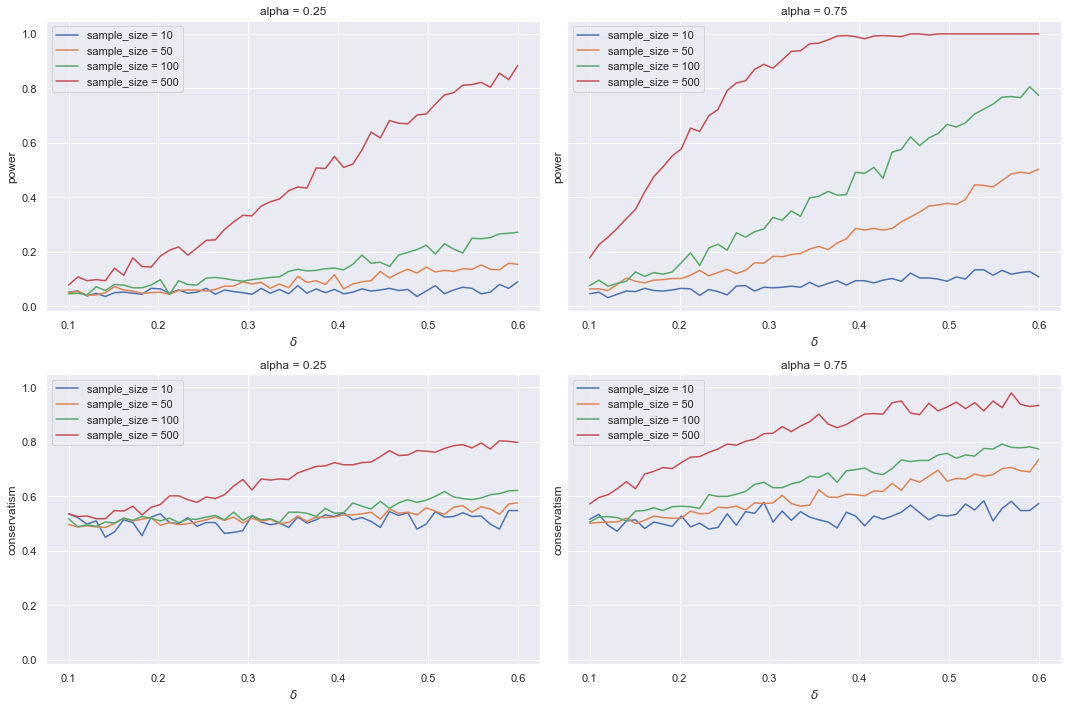

In [183]:
n_alphas = 2
n_deltas = 50
n_samples = 500

alphas = np.linspace(0.25, 0.75, n_alphas)
deltas = np.linspace(0.1, 0.6, n_deltas)
sample_size = [10, 50, 100, 500]

fig, axes = plt.subplots(2, alphas.shape[0],
                       figsize=(15, 10), sharex=False, sharey=True)

for idx, alpha in enumerate(alphas):
    for size in sample_size:
        pvalues = np.zeros((n_samples, n_deltas))
        alpha_array = np.full_like(deltas, alpha)
        for i in range(n_samples):
            pvalues[i,:] = get_data(alpha_array, deltas, sample_size=size, 
                               seed=idx * n_samples + i, verbose=False, only_stat=True)
    
        sns.lineplot(x=deltas, y=(pvalues<0.05).mean(axis=0), 
                     ax=axes[0, idx], label="sample_size = {}".format(size))\
        .set(title="alpha = {}".format(*np.around([alpha], decimals=2)),
            xlabel="$\delta$", ylabel="power")
        sns.lineplot(x=deltas, y=(pvalues<pvalues.mean(axis=0)).mean(axis=0), 
                     ax=axes[1, idx], label="sample_size = {}".format(size))\
        .set(title="alpha = {}".format(*np.around([alpha], decimals=2)),
            xlabel="$\delta$", ylabel="conservatism")
fig.tight_layout()
plt.show()

Зависимости на лицо, размер выборки очень сильно влияет на мощность критерия, в особенности при больших $\alpha$.

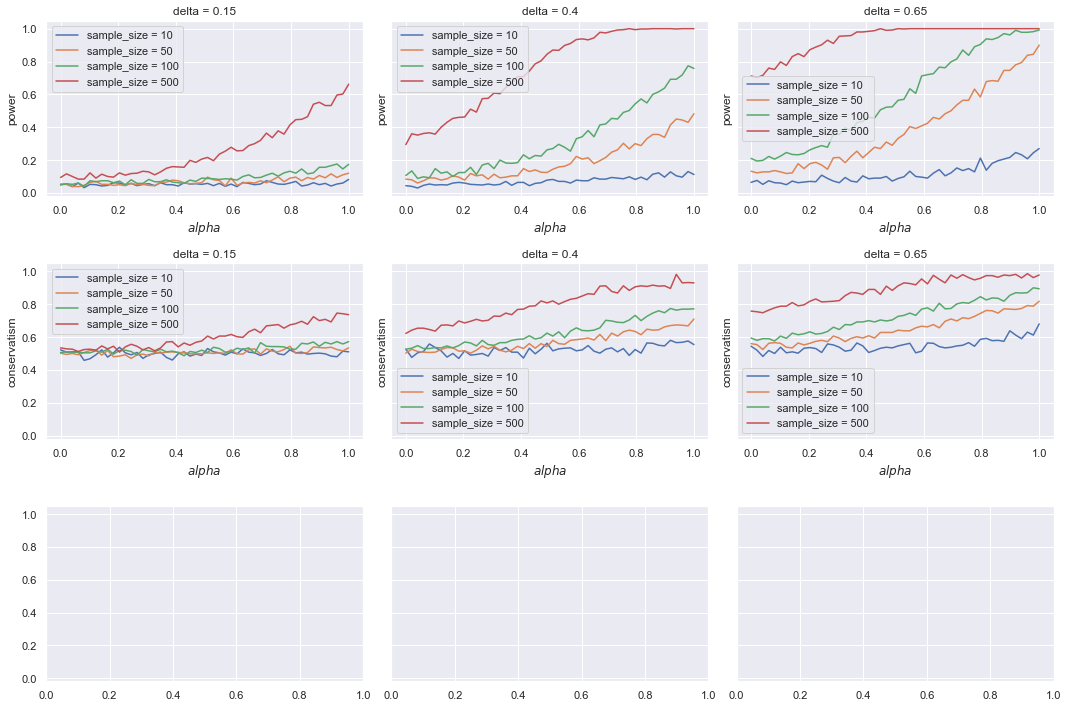

In [185]:
n_alphas = 50
n_deltas = 3
n_samples = 500

alphas = np.linspace(0.0, 1.0, n_alphas)
deltas = np.linspace(0.15, 0.65, n_deltas)
sample_size = [10, 50, 100, 500]

fig, axes = plt.subplots(2, deltas.shape[0],
                       figsize=(15, 10), sharex=False, sharey=True)

for idx, delta in enumerate(deltas):
    for size in sample_size:
        pvalues = np.zeros((n_samples, n_alphas))
        delta_array = np.full_like(alphas, delta)
        for i in range(n_samples):
            pvalues[i,:] = get_data(alphas, delta_array, sample_size=size, 
                               seed=idx * n_samples + i, verbose=False, only_stat=True)
    
        sns.lineplot(x=alphas, y=(pvalues<0.05).mean(axis=0), 
                     ax=axes[0, idx], label="sample_size = {}".format(size))\
        .set(title="delta = {}".format(*np.around([delta], decimals=2)),
            xlabel="$alpha$", ylabel="power")
        sns.lineplot(x=alphas, y=(pvalues<pvalues.mean(axis=0)).mean(axis=0), 
                     ax=axes[1, idx], label="sample_size = {}".format(size))\
        .set(title="delta = {}".format(*np.around([delta], decimals=2)),
            xlabel="$alpha$", ylabel="conservatism")
fig.tight_layout()
plt.show()

Та же самая картина, в особенности сильно размер выборки начинает влиять при достаточно больших $\alpha$.